# Training a Machine Learning Classifier for HP-PPI Prediction Task

Classifier: XGBoost
- performs well with sparse variables
- needs no preprocessing

In [7]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall
from hyperopt import hp, tpe, STATUS_OK, Trials, space_eval
from hyperopt.fmin import fmin

from IPython.display import display, Markdown

# Suppress warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.simplefilter('ignore', category=(UndefinedMetricWarning, RuntimeWarning))

In [3]:
# Set up directories
SEED = 714903286
parent_dir = os.path.dirname(os.getcwd())

dir_in = os.path.join(parent_dir, 'data', 'features')
dir_out = os.path.join(parent_dir, 'data', 'results')

In [4]:
# Function for combining datasets
def get_dataset(pathogens):
    '''Combine features and labels of different pathogen datasets'''
    
    X = []
    y = []
    
    # Iterate through datasets
    for pathogen in pathogens:
        f_in = os.path.join(dir_in, '%s_features.pkl' % pathogen)
        X_, y_ = joblib.load(f_in)
        X.append(X_)
        y.append(y_)
    
    # Combine features (X) and labels (y)
    X = sparse.vstack(X)
    y = np.concatenate(y)
    
    return X, y

## Hyperparameter Tuning

Bayesian optimization with `hyperopt`

In [5]:
# Load all datasets
pathogens = ['Bacan', 'Yerpe', 'Fratu']
X, y = get_dataset(pathogens)
print('Loaded %i samples with %i features' % X.shape)

# Split into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8,
                                                      stratify=y, random_state=SEED)

# Set up base classifier
clf = XGBClassifier(n_estimators=2000, random_state=SEED, n_jobs=-1)

Loaded 64234 samples with 4456 features


In [5]:
# Define objective function
def objective(params):
    _ = clf.set_params(**params)
    _ = clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
                eval_metric='aucpr', early_stopping_rounds=100,
                verbose=False)
    
    score = average_precision_score(y_valid, clf.predict_proba(X_valid))
    return {'loss': -score, 'status': STATUS_OK}

In [6]:
# Define hyperparameter search space
param_space = {
    'max_depth': hp.choice('max_depth', range(1, 51)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),
    'min_child_weight': hp.choice('min_child_weight', range(11)),
    'max_delta_step': hp.choice('max_delta_step', range(31)),
    'gamma': hp.uniform('gamma', 0, 2.0),
    
    'subsample': hp.uniform('subsample', 0.4, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.6, 1),
    
    'reg_alpha': hp.loguniform('reg_alpha', -6 * np.log(10), np.log(10)),
    'reg_lambda': hp.loguniform('reg_lambda', -6 * np.log(10), 2 * np.log(10)),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.1, 10)
}

# Begin optimization
trials = Trials()
best = fmin(objective, param_space, algo=tpe.suggest, max_evals=100, trials=trials)

# Obtain parameters of best model
best_params = space_eval(param_space, best)
best_params

100%|██████████| 200/200 [3:04:01<00:00, 54.92s/it, best loss: -0.8301610541727673]


{'colsample_bylevel': 0.6849128114353873,
 'colsample_bytree': 0.8350733287910092,
 'gamma': 1.3739792101034978,
 'learning_rate': 0.4702921823824479,
 'max_delta_step': 3,
 'max_depth': 36,
 'min_child_weight': 0,
 'reg_alpha': 0.0077629401231028745,
 'reg_lambda': 1.5854041633330762,
 'scale_pos_weight': 1.4741540044725339,
 'subsample': 0.9987782265033653}

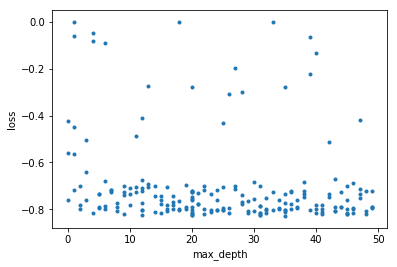

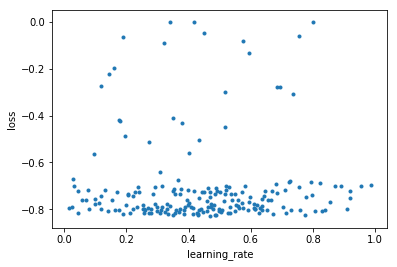

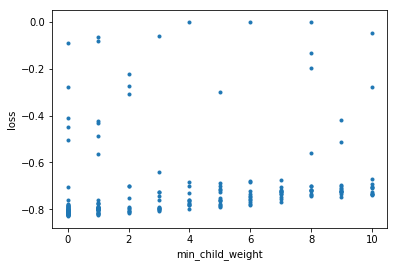

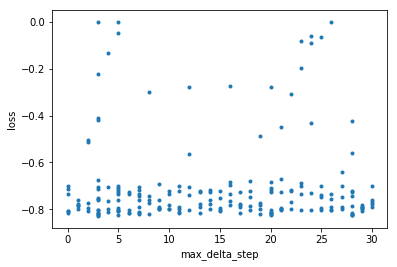

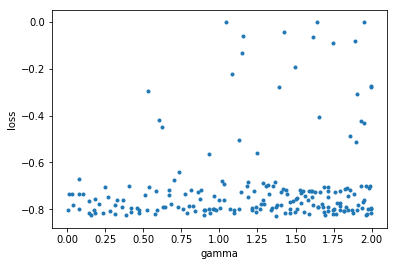

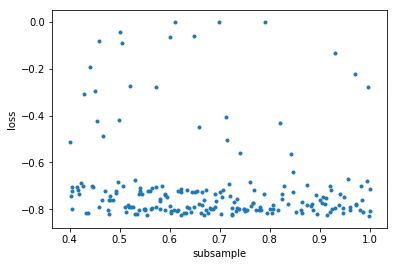

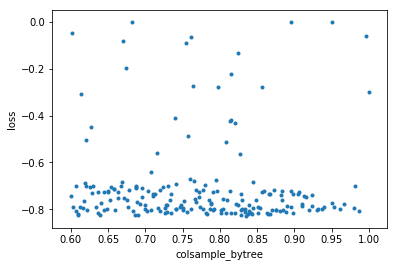

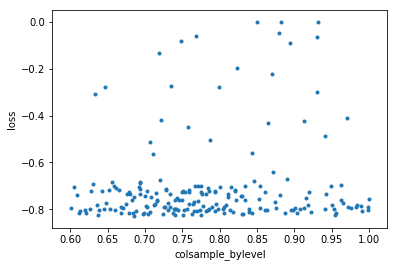

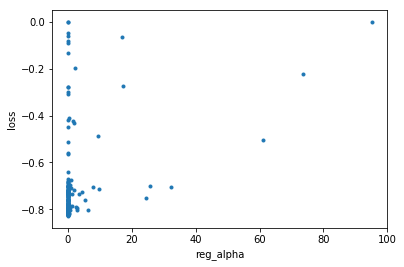

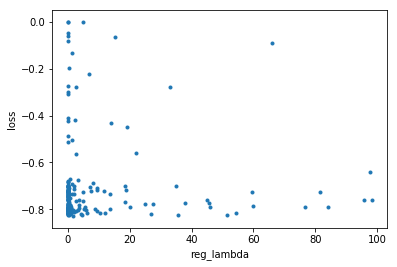

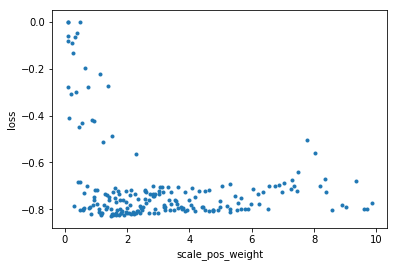

In [7]:
# Plot optimization progress: parameters vs loss
%matplotlib inline

for param in param_space.keys():
    xs = [t['misc']['vals'][param] for t in trials.trials]
    ys = [t['result']['loss'] for t in trials.trials]
    
    _ = plt.scatter(xs, ys, marker='.')
    _ = plt.xlabel(param)
    _ = plt.ylabel('loss')
    _ = plt.show()

In [16]:
# Set up classifier
_ = clf.set_params(**best_params)

# Train with validation
_ = clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
            eval_metric='aucpr', early_stopping_rounds=100,
            verbose=1)

# Dump model as pickle
_ = joblib.dump(clf, 'best_model.pkl')

[0]	validation_0-error:0.09838	validation_0-f1-error:0.713912
Multiple eval metrics have been passed: 'validation_0-f1-error' will be used for early stopping.

Will train until validation_0-f1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.092349	validation_0-f1-error:0.647727
[2]	validation_0-error:0.091629	validation_0-f1-error:0.620732
[3]	validation_0-error:0.09586	validation_0-f1-error:0.682255
[4]	validation_0-error:0.094779	validation_0-f1-error:0.670274
[5]	validation_0-error:0.092169	validation_0-f1-error:0.626683
[6]	validation_0-error:0.090009	validation_0-f1-error:0.59312
[7]	validation_0-error:0.087219	validation_0-f1-error:0.566998
[8]	validation_0-error:0.085239	validation_0-f1-error:0.546451
[9]	validation_0-error:0.084608	validation_0-f1-error:0.540852
[10]	validation_0-error:0.083978	validation_0-f1-error:0.534058
[11]	validation_0-error:0.082358	validation_0-f1-error:0.517827
[12]	validation_0-error:0.081818	validation_0-f1-error:0.506407
[13]	validati

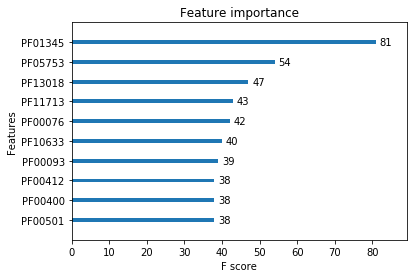

In [19]:
# Examine parameter importance
## Assign feature names
pfam = joblib.load('pfam.pkl')[1]

clf.get_booster().feature_names = pfam
_ = plot_importance(clf.get_booster(), importance_type='gain', max_num_features=10, grid=False)

## Evaluate model on partitioned datasets

                               Test 1                                
                          Test Pathogen: Bacan
                          
              precision    recall  f1-score   support

           0     0.9608    0.9662    0.9635     21106
           1     0.7302    0.6990    0.7142      2764

    accuracy                         0.9352     23870
   macro avg     0.8455    0.8326    0.8389     23870
weighted avg     0.9341    0.9352    0.9346     23870



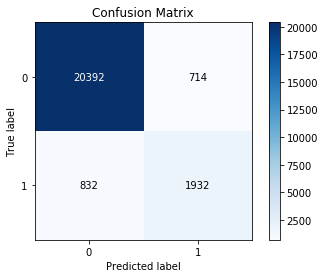

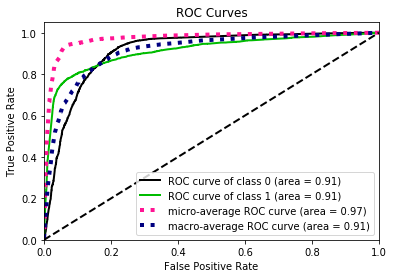

<hr></hr>

                               Test 2                                
                          Test Pathogen: Yerpe
                          
              precision    recall  f1-score   support

           0     0.9615    0.9728    0.9671     28088
           1     0.7658    0.6950    0.7287      3590

    accuracy                         0.9413     31678
   macro avg     0.8636    0.8339    0.8479     31678
weighted avg     0.9393    0.9413    0.9401     31678



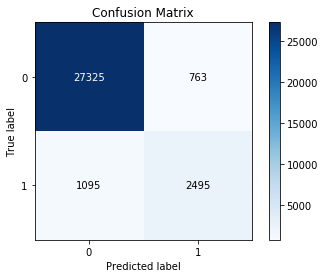

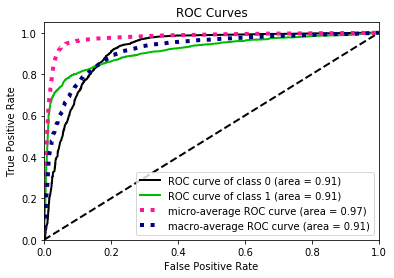

<hr></hr>

                               Test 3                                
                          Test Pathogen: Fratu
                          
              precision    recall  f1-score   support

           0     0.9603    0.9931    0.9764      7499
           1     0.9441    0.7405    0.8300      1187

    accuracy                         0.9586      8686
   macro avg     0.9522    0.8668    0.9032      8686
weighted avg     0.9581    0.9586    0.9564      8686



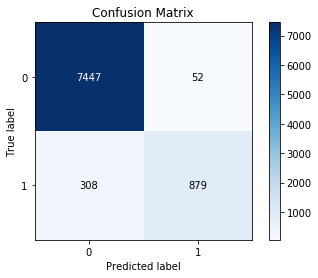

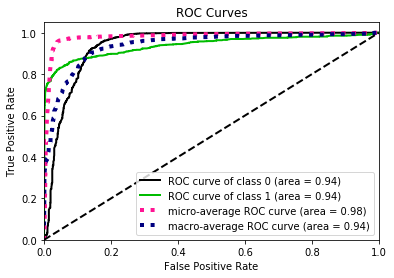

<hr></hr>

In [9]:
# Train and test classifier on different datasets
## Partition datasets by pathogen species
%matplotlib inline
i = 0 # track number of tests

for p_test in pathogens:
    p_train = [p for p in pathogens if p != p_test]
    X_train, y_train = get_dataset(p_train)
    
    # Train classifier with validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8,
                                                          stratify=y_train, random_state=SEED)
    
    _ = clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
                eval_metric='aucpr', early_stopping_rounds=100,
                verbose=0)
    
    # Evaluate performance on test set
    X_test, y_test = get_dataset([p_test])
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    
    i += 1
    
    print('Test %i'.center(70) % i)
    print('Test Pathogen: %s\n'.center(70) % p_test)
    print(classification_report(y_test, y_pred, digits=4))
    
    # Plot metrics
    _ = plot_confusion_matrix(y_test, y_pred)
    _ = plot_roc(y_test, y_proba)
    _ = plot_precision_recall(y_test, y_proba)
    _ = plt.show()
    
    display(Markdown('<hr></hr>'))